<a href="https://colab.research.google.com/github/QwertyJacob/colab_handouts_PSI/blob/main/BONUSX_ActiveInference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A hopefully simple tutorial on Active inference for continuous PO-MDPs
_______
By Jesus Cevallos


## Markov Decision Processes

### Why we need Markov Decision Processes



Imagine an agent — a robot, an animal, or even a thermostat — that interacts with an environment over time.  
At each moment:

- The environment has **some state**, describing what is going on.
- The agent takes **an action**.
- The environment changes in response.
- The agent receives **feedback** (in reinforcement learning) or *perceptions* (in active inference).

To reason about such interactions, we need a mathematical model that:

- Represents how the world evolves over time  
- Represents how the agent influences the world  
- Allows us to compute or infer how good (or *expected*) different action sequences are  

The simplest such model is a **Markov Decision Process (MDP)**.

### What is a Markov Decision Process?

An MDP is defined by:

$$
\mathcal{M} = (\mathcal{S},\mathcal{A},P(s_{t+1}\mid s_t, a_t), R(s_t,a_t))
$$

Where:

- **$\mathcal{S}$** is the set of possible *states* of the world  
- **$\mathcal{A}$** is the set of possible *actions* the agent can take  
- **$P(s_{t+1} \mid s_t, a_t)$** is the probability of the next state  
- **$R(s_t,a_t)$** (only in RL) is a reward function  

### The Markov Property






The key assumption that makes MDPs simple and powerful is:

$$
\text{The future depends only on the present, not on the whole past.}
$$

Formally:

$$
P(s_{t+1} \mid s_{0:t}, a_{0:t}) = P(s_{t+1} \mid s_t, a_t).
$$

This is a *memorylessness* assumption.  
The idea is: **the present state summarizes all relevant information about the past**.

This dramatically simplifies computations.

Without the Markov assumption, state prediction would require the entire history, which is computationally explosive.


### The Graphical (Causal) Structure of an MDP



An MDP can be expressed as a causal diagram (run cell bellow):

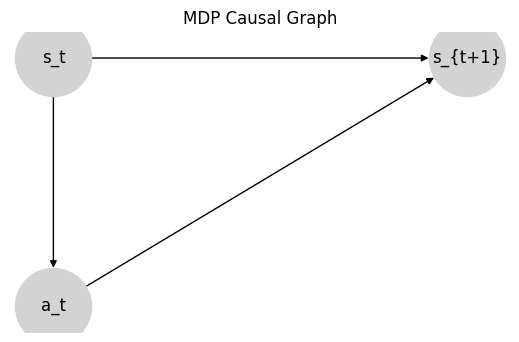

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

G.add_nodes_from(["s_t", "a_t", "s_{t+1}"])

G.add_edges_from([
    ("s_t", "a_t"),        # Policy depends on state
    ("s_t", "s_{t+1}"),    # Transition depends on state
    ("a_t", "s_{t+1}")     # Transition also depends on action
])

pos = {
    "s_t": (0, 1),
    "a_t": (0, 0),
    "s_{t+1}": (2, 1)
}

plt.figure(figsize=(5,3))
nx.draw(G, pos, with_labels=True, node_color="lightgray", node_size=3000)
plt.title("MDP Causal Graph")
plt.show()

Where the arrows mean “causes” or “influences”.

More explicitly:

- The state at time $t$ causes the next state  
- The action also contributes causally  

MDPs are called **fully observable** because states are supposed to be visible.

### Why MDPs Are Not Enough



MDPs assume the agent *sees* the world’s true state $s_t$.

But in real life:

* A robot only sees sensor readings
* A human only perceives noisy sensory data
* A self-driving car sees camera images, not true distances
* A rat navigating a maze does not know which room it is in with certainty

In all realistic situations, the agent receives **uncertain** or **indirect** information about the true state.

This motivates **Partially Observed MDPs (POMDPs)**.

### From MDPs to POMDPs: The Need for Hidden States



In a POMDP, the agent receives **observations**:

* $o_t$ is what the agent *observes*
* $s_t$ is the true (hidden) state
* There is a mapping (likelihood model)
  $$
  P(o_t \mid s_t)
  $$

This makes the problem **much more realistic**, because it models:

* sensor noise
* perceptual ambiguity
* incomplete information
* uncertainty about what is happening


### Formal Structure of a POMDP



A POMDP is:

$$
\mathcal{P} = (\mathcal{S}, \mathcal{A}, \mathcal{O},
P(s_{t+1}\mid s_t,a_t), P(o_t\mid s_t))
$$

Differences from MDP:

* Observations $o_t$ are noisy functions of hidden states
* Agent must **infer** states from observations
* This leads to beliefs, filtering, and Bayesian inference

In other words, we go from:

MDP:
**State is known → choose action**

POMDP:
**State is unknown → infer hidden state → choose action**


### The Causal Graph of a POMDP



A POMDP can be visualized running the cell below:

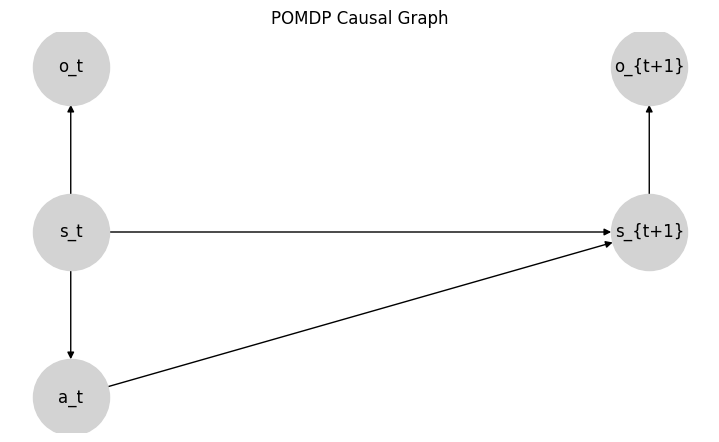

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

nodes = ["s_t", "a_t", "s_{t+1}", "o_t", "o_{t+1}"]
G.add_nodes_from(nodes)

edges = [
    ("s_t", "a_t"),
    ("s_t", "o_t"),
    ("s_t", "s_{t+1}"),
    ("a_t", "s_{t+1}"),
    ("s_{t+1}", "o_{t+1}")
]

G.add_edges_from(edges)

pos = {
    "s_t": (0, 1),
    "a_t": (0, 0),
    "o_t": (0, 2),
    "s_{t+1}": (2, 1),
    "o_{t+1}": (2, 2)
}

plt.figure(figsize=(7,4))
nx.draw(G, pos, with_labels=True, node_color="lightgray", node_size=3000)
plt.title("POMDP Causal Graph")
plt.show()

* Hidden states cause observations
* Hidden states evolve based on actions

This structure is **exactly** the generative model used in active inference.


### Conditional Independences in POMDPs




The heart of the POMDP structure is the **conditional independence** that hidden states enforce:

#### Observations depend only on the current hidden state

$$
 P(o_t \mid s_t, a_{t-1}, s_{t-1}, o_{t-1}, \ldots) = P(o_t \mid s_t)
$$

Meaning:

> Once you know the current hidden state, the observation no longer depends on the past. (Note that observations are also independent of previous actions given states...)

This is a **causal shielding** property.

#### State transitions depend only on current state and action

$$
P(s_{t+1} \mid s_t, a_t, s_{t-1}, o_{t-1}, \ldots) = P(s_{t+1} \mid s_t, a_t)
$$

The hidden state encodes all relevant information for prediction. (We do not care about previous observations either)

## The Generative Process vs. The Generative Model



Up to this point, we've described the **generative process**: the actual, external dynamics of the world as modeled by a POMDP. This is the "true" mechanism by which hidden states evolve, actions influence those states, and observations are generated. In the generative process, we use probabilities denoted by $P$, such as $P(s_{t+1} \mid s_t, a_t)$ for state transitions and $P(o_t \mid s_t)$ for the likelihood of observations given states.

However, the agent (e.g., a robot or animal) does not have direct access to this true process. Instead, the agent maintains an internal **generative model**: a probabilistic representation of how it *believes* the world works. This model allows the agent to infer hidden states from observations, predict future outcomes, and plan actions. The generative model is "specular" (mirror-like) to the generative process—it has a similar structure—but it represents the agent's subjective beliefs, which may approximate or diverge from the true process.

In active inference, we denote the distributions in the generative model with $Q$ to distinguish them from the true $P$ distributions of the process. For example:
- $Q(s_{t+1} \mid s_t, a_t)$ approximates the state transition.
- $Q(o_t \mid s_t)$ approximates the observation likelihood.

The key difference:
- **Generative Process ($P$)**: The objective, external world dynamics (often unknown to the agent).
- **Generative Model ($Q$)**: The agent's internal, subjective model used for inference and decision-making. It is learned or updated over time to better match the process.

### Factorization Under the Markovian Assumption



Under the Markovian assumption (as in the POMDP structure), the generative model factorizes according to the conditional independencies in the causal graph. This means the joint probability breaks down into simpler, local conditional distributions, making computations tractable.

Recall the POMDP causal structure: Hidden states evolve based on previous states and actions, and observations depend only on the current hidden state. Actions are chosen based on inferred states (via a policy, which we'll discuss later).

The factorization of the generative model is:
$$
Q(s_{0:T}, a_{0:T-1}, o_{0:T}) = Q(s_0) \prod_{t=0}^{T-1} Q(s_{t+1} \mid s_t, a_t) \cdot Q(a_t \mid s_t) \cdot \prod_{t=0}^{T} Q(o_t \mid s_t)
$$

Breaking it down:
- $Q(s_0)$: Prior belief over the initial hidden state.
- $Q(s_{t+1} \mid s_t, a_t)$: Believed state transition model (Markovian: depends only on current state and action).
- $Q(a_t \mid s_t)$: The agent's policy, specifying actions given inferred states.
- $Q(o_t \mid s_t)$: Likelihood model (observations depend only on the current hidden state).

This factorization mirrors the generative process but uses $Q$ to reflect the agent's approximate beliefs. The Markovian property ensures that each term depends only on immediate predecessors, "shielding" the future from the distant past.

### Model Inversion: Inferring Hidden States via Bayes' Theorem



Once the agent has initialized its **generative model** $Q(s_{0:T}, a_{0:T-1}, o_{0:T})$, its primary task is to **invert** this model to infer the hidden states that best explain the observed data. This inversion is the core of perception in active inference and is performed using **Bayes' theorem**.

Let:
- $\underline{o} \triangleq o_{0:t}$: the sequence of past observations (including current time $t$),
- $\underline{a} \triangleq a_{0:t-1}$: the sequence of past actions

The agent wants to compute the **posterior belief** over the current hidden state $s_t$ (denoted $s_t$ for current time) given all past observations and actions:
$$
Q(s_t \mid \underline{o}, \underline{a})
$$

This posterior represents the agent's **inferred belief** about the current state of the world.

### Bayesian Model Inversion



Using Bayes' theorem in the generative model:

$$
\boxed{
Q(s_t \mid \underline{o}, \underline{a})
= \frac{Q(\underline{o} \mid \underline{a}, s_t) \cdot Q(s_t \mid \underline{a})}{Q(\underline{o} \mid \underline{a})}
}
$$

This is **exact Bayesian inference** within the agent's internal model:
- $Q(\underline{o} \mid \underline{a}, s_t)$: **Likelihood** — how well the current state would explain the observations (via $Q(o_t \mid s_t)$).
- $Q(s_t \mid \underline{a})$: **Prior** — the predicted state under the agent's past actions.
- $Q(\underline{o} \mid \underline{a})$: **Model evidence** (marginal likelihood) — normalizes the posterior.


### Exploiting Conditional Independence (Markov Structure)




Thanks to the **Markovian assumptions** in the generative model, many terms become conditionally independent. In particular:
- Each observation $o_t$ depends **only** on its contemporaneous state $s_t$,
- Each state transition $s_{t+1}$ depends **only** on $s_t$ and $a_t$.

This allows us to simplify the likelihood:
$$
Q(\underline{o} \mid \underline{a}, s_t) = Q(\underline{o} \mid s_t) = \prod_{k=0}^{\tau-1} Q(o_k \mid s_k)
$$

So the full posterior becomes:

$$
\boxed{
Q(s_t \mid \underline{o}, \underline{a})
= \frac{
\overbrace{Q(\underline{o} \mid s_t)}^{\text{likelihood over all obs}}
\cdot
\overbrace{Q(s_t \mid \underline{a})}^{\text{prior state distribution}}
}{
\underbrace{Q(\underline{o} \mid \underline{a})}_{\text{marginal likelihood or evidence}}
}
} \tag{1}
$$

The **marginal likelihood** of the observations under the agent’s generative model, in principle is the result of a marginalisation (hence the name):

$$
Q(\underline{o} \mid \underline{a}) = \int Q(\underline{o}, s_t \mid \underline{a}) \, ds_t
= \int \underbrace{Q(\underline{o} \mid s_t)}_{\text{likelihood}} \cdot \underbrace{Q(s_t \mid \underline{a})}_{\text{prior over trajectories}} \, ds_t
$$

This is a **high-dimensional integral** over all possible states sequences $s_t$. For even moderately discrete or continuous state spaces, this integral is **intractable** — it cannot be computed exactly.

Thus, **exact Bayesian inference** is generally infeasible in real-time agents.

### A useful approximation:



To make inference tractable, we introduce a **_variational_ distribution** $q_{\underline{o}}(s_t\mid \underline{a})$ — a simpler, factorized family of distributions whose PDF will be a function of $\underline{o}$. (We would say that $\underline{o}$ are sufficient statistics for $q$). This parameterized distribution **approximates** the true posterior $Q(s_t \mid \underline{o}, \underline{a})$. We restrict $q_{\underline{o}}(s_t\mid \underline{a})$ to a family of distributions that are easy to evaluate and update (e.g., mean-field, Gaussian, recurrent neural network approximations).

The goal: **minimize the difference** between $q_{\underline{o}}(s_t\mid \underline{a})$ and the true posterior:

$$
    D_{KL}\left[ q_{\underline{o}}(s_t\mid \underline{a}) || Q(s_t \mid \underline{o}, \underline{a})  \right]   \rightarrow 0 \tag{2}
$$

But we can't directly minimise this divergence because the true posterior, $ Q(s_t \mid \underline{o}, \underline{a})$ is unknown because it itself depends on the intractable evidence $Q(\underline{o} \mid \underline{a})$!

(Notice that, if $ Q(s_t \mid \underline{o}, \underline{a})$ were computable, we would be talking about variational inference at all!)

So we will minimise $(2)$ indirectly by minimising a quantity that we call Variational Free Energy. To see how, let's take a closer look to the KL divergence in $(2)$:

$$
\begin{aligned}
    D_{KL}\left[ q_{\underline{o}}(s_t\mid \underline{a}) || Q(s_t \mid \underline{o}, \underline{a})  \right]   &=
    \mathbb{E}_{q_{\underline{o}}(s_t\mid \underline{a})}\left[ \ln q_{\underline{o}}(s_t\mid \underline{a}) - \ln Q(s_t \mid \underline{o}, \underline{a}) \right]\\\\
    &\text{using the definition of conditional probability: }\\
    &\left( Q(s_t \mid \underline{o}, \underline{a})=
                \frac{
            Q(\underline{o}, s_t \mid \underline{a})
            }{
            Q(\underline{o} \mid \underline{a})
            }
    \right)\\
    &\left( \ln Q(s_t \mid \underline{o}, \underline{a})=
            \ln Q(\underline{o}, s_t \mid \underline{a}) - \ln Q(\underline{o} \mid \underline{a})\right) \\\\
     &\text{substituting this into the KL divergence:}\\
    &=\mathbb{E}_{q_{\underline{o}}(s_t\mid \underline{a})}\left[ \ln q_{\underline{o}}(s_t\mid \underline{a}) - \ln Q(\underline{o}, s_t \mid \underline{a}) + \ln Q(\underline{o} \mid \underline{a}) \right]\\\\
    &\text{The third term can get out of the expectation:}\\
    &=\mathbb{E}_{q_{\underline{o}}(s_t\mid \underline{a})}\left[ \ln q_{\underline{o}}(s_t\mid \underline{a}) -\ln Q(\underline{o}, s_t \mid \underline{a})\right] + \ln Q(\underline{o} \mid \underline{a}) \\\\
    &\text{By definition of KL divergence:}\\
    &=D_{KL}\left[ q_{\underline{o}}(s_t\mid \underline{a}) || Q(\underline{o}, s_t \mid \underline{a})\right]+ \ln Q(\underline{o} \mid \underline{a})
\end{aligned}
$$

Let's look again to the identity we have just found, let's add some names to the terms in this expression:

$$
    \underbrace{D_{KL}\left[ q_{\underline{o}}(s_t\mid \underline{a}) || Q(s_t \mid \underline{o}, \underline{a})  \right]}_{\text{Approximation error}}  =
    \underbrace{D_{KL}\left[ q_{\underline{o}}(s_t\mid \underline{a}) || Q(\underline{o}, s_t \mid \underline{a})\right]}_{\textit{Variational Free Energy}}+ \underbrace{\ln Q(\underline{o} \mid \underline{a})}_{\text{log evidence}}
$$

This tell's us that, even if we are not able to minimise the approximation error directly, **we can minimise the approximation error vicariously by minimising Variational Free Energy (VFE)**, whatever the VFE actually is.

Let's also put in evidente the log-evidence, which we know is a good thing to maximise:

$$

    \underbrace{\ln Q(\underline{o} \mid \underline{a})}_{\text{log evidence}} =  \underbrace{D_{KL}\left[ q_{\underline{o}}(s_t\mid \underline{a}) || Q(s_t \mid \underline{o}, \underline{a})  \right]}_{\text{Approximation error}}  - \underbrace{D_{KL}\left[ q_{\underline{o}}(s_t\mid \underline{a}) || Q(\underline{o}, s_t \mid \underline{a})\right]}_{\textit{Variational Free Energy}}
$$

Looking things from this point of view, we are even more convinced that minimising the VFE is actually a good idea: it will maximise the evidence of our generative model!

Now, the only question is, what a heck is the VFE? Let's put a second in evidence this term:

$$
    \underbrace{D_{KL}\left[ q_{\underline{o}}(s_t\mid \underline{a}) || Q(\underline{o}, s_t \mid \underline{a})\right]}_{\textit{Variational Free Energy}}
    =  \underbrace{D_{KL}\left[ q_{\underline{o}}(s_t\mid \underline{a}) || Q(s_t \mid \underline{o}, \underline{a})  \right]}_{\text{Approximation error}} - \underbrace{\ln Q(\underline{o} \mid \underline{a})}_{\text{\textit{log evidence}}}  
$$

We now see hoe the VFE is an upper bound on the negative of the log evidence (which is also called surprisal). If we need to maximise evidence to construct a good generative model, we should minimise surprisal. Again, this expression convinces us that, by minimising the VFE _functional_ (a functional is a function of a function), we are vicariously minimising surprise, because the VFE is an upper bound on it. Conversely, if we minimise VFE we maximise Evidence because the VFE is a lower bound of it. (in fact, ML fellas call the "Evidence Lower Bound" or ELBo to the negative of VFE).

## The Variational Free Energy:

The Variational Free Energy is a KL divergence:

$$
VFE = D_{KL}\left[ q_{\underline{o}}(s_t\mid \underline{a}) || Q(\underline{o}, s_t \mid \underline{a}) \right] \tag{3}
$$

There are many ways to understand such a divergence, depending on how we factorise it:

$$
\begin{aligned}
VFE &= D_{KL}\left[ q_{\underline{o}}(s_t\mid \underline{a}) || Q(\underline{o}, s_t \mid \underline{a}) \right] \\
&
= \mathbb{E}_{q_{\underline{o}}(s_t\mid \underline{a})}\left[ \ln q_{\underline{o}}(s_t\mid \underline{a}) - \ln Q(\underline{o}, s_t \mid \underline{a}) \right] \\
& = - \underbrace{\mathbb{H}[q_{\underline{o}}(s_t\mid \underline{a})]}_{\text{Neutrality}} - \underbrace{\mathbb{E}_{q_{\underline{o}}(s_t\mid \underline{a})}[Q(\underline{o}, s_t \mid \underline{a})}_{\text{Consistency}}]
\end{aligned}
\tag{3.1}
$$

The first way of understanding the VFE $(3.1)$ is looking it as the summation of two terms:
- the negative entropy of the variational distribution: The entropy is a measure of neutrality, a measure of spread. The more entropy, the less specific our distribution is, and so it may accomodate a bigger set of distributions. We should maximise the entropy a priori. This is a well-noted principle in many fields of physics, neuroscience and information theory. By maximising this entropy or neutrality of first guesses, we are minimising the VFE, which we know is a good thing to do.

- the negative crossentropy of the joint with respect to the variational distribution. This thing should be maximised, because joint used here is supposed to be normative, i.e. it encodes the states, behaviour and observations the agent should have. This cross-entropy thus encodes a more pragmatic goal. Maximises this cross-entropy also minimises the VFE, so we are good to do so.

Let's look at a second way of expressing the VFE:

$$
\begin{aligned}
VFE &= D_{KL}\left[ q_{\underline{o}}(s_t\mid \underline{a}) || Q(\underline{o}, s_t \mid \underline{a}) \right] \\
&
= \mathbb{E}_{q_{\underline{o}}(s_t\mid \underline{a})}\left[ \ln q_{\underline{o}}(s_t\mid \underline{a}) - \ln Q(\underline{o}, s_t \mid \underline{a}) \right] \\
& = \mathbb{E}_{q_{\underline{o}}(s_t\mid \underline{a})}\left[ \ln q_{\underline{o}}(s_t\mid \underline{a}) - \ln Q(\underline{o} \mid s_t) - \ln Q(s_t \mid \underline{a})\right] \\
& = \mathbb{E}_{q_{\underline{o}}(s_t\mid \underline{a})}\left[ \ln q_{\underline{o}}(s_t\mid \underline{a})  - \ln Q(s_t \mid \underline{a}) \right]- \mathbb{E}_{q_{\underline{o}}(s_t\mid \underline{a})}\left[\ln Q(\underline{o} \mid s_t)\right] \\
& =  \underbrace{D_{KL} \left[ q_{\underline{o}}(s_t\mid \underline{a}) || Q(s_t \mid \underline{a}) \right]}_{\text{Complexity}} - \underbrace{\mathbb{E}_{q_{\underline{o}}(s_t\mid \underline{a})}\left[ \ln Q(\underline{o} \mid s_t) \right]}_{\text{Accuracy}} \\
\end{aligned}
\tag{3.2}
$$

- here the complexity term is measuring the divergence between our approximate posterior and the form of the prior. Again, here the prior is assumed to be our goal, our guide. So we are measuring here how much "work" we should do to build a posterior  (i.e. a prior informed by evidence) whic fits with the real distribution of states given the same actions. Minimising such divergence is a good thing to do if we consider that the actions are already taken so, irrespective of the evidence, the final state we are in should be the same if we take the same actions...
- The accuracy is more of an expectation of evidence. Again, the distribution whose expectation we are computing, $Q(\underline{o} \mid s_t)$ is a normative one, like a ground thruth that tell's us what is really the distribution of ovservations we should expect when beign in state $s_t$, it is a good thing if the probability of $\underline{o}$ is maximised when the expcation is computed over $q_{\underline{o}}(s_t\mid \underline{a})$, i.e., when we are using $\underline{o}$ to build our approximate posterior.

> We will use eiter $(3.1)$ or $(3.2)$ in our experiments as a ground truth signal that gives us a bayes optimal way of using our generative model at each moment.

## The Expected Free Energy (EFE)


So far so good, we've seen how to build a structure for implementing an agent (the MDP), how to make that structure more compliant with uncertainty (the POMDP), and how to update the generative model of an agent (minimisng the VFE).

Now the thing is, we've so far talked about a retroscpectively updating such a model to be consistent with a series of PAST observations, actions and states.

It turns out that an AGENT also ACTS, i.e., it not only passively observes "evidence" but it could also actively "drive" the course of its future observations.

Taking into account this prospective side of agency makes things interesting when adopting the bayesian framework we are doing.

In particular, we could impose a distribution of observations that periodically our agent oughts to see, being aware of the fact that he cannot directly steer its observations but can only vicariously drive these through actions.

By using this laanguage, we can say that an intelligent or compliant agent is the one who acts to succesfully achieve some observations. This formulation is akin to cybernetics, or, in other words, the fisiology of artificial agents: To exist, an agent has to maintain a distribution of observations in its steady state, admist the fluctuations derived form the environment that would drive it to "death" or "malfunction" unless it actively mitigates this phenomena.

In other words, when we speak about the next or future actions, we could use our VFE bayesian machinery to choose the best actions to make as beign the ones which will minimise the VFE in the future. The VFE in the future is called the Expected Free Energy and is the last functional we study in this tutorial as a criterion for policy shaping, i.e., for choosing actions.

### Looking forward

The expected free energy can be seen as the expectation of variational free energy over a sequence of future states and observations before we actually see them. The unique thing to keep in mind is that these future observations are provoked by a sequence of actions, and that the future observations themselves provoke a future sequence of states. To keep such a causality chain as correct as possible we chiarify were we are now in terms of time:

- suppose we are now at instant $t$.
- we want to plan the future $h$ actions. (we say that $h$ is our _planning horizon_)
- we can see $o_t$, and we can _infer_ $s_t$ using model inversion, as explained before.
- we want to choose the next action, which is actually $a_t$ (not $a_{t+1}$!, cuz initial state was $s_0$, initial obsrvation was $o_0$, and the initial action, taken while being at $s_0$ and after bserving $o_0$ was $a_0$. See? actions are one-step backwards... Actually $a_0$ provokes $s_1$ and $s_1$ provokes $o_1$...)
- if we where to choose not only our next action, $a_t$ but a next sequence of $h$ actions, then we want to choose $a_t, a_{t+1}, a_{t+2},... a_{t+h}$
- so we denote $\bar{a} = \{a_t,a_{t+1},...a_{t+h}\}$ and those fellas will generate $s_{t+1}, s_{t+2}, ..., s_{t+h+1}$
- so we use $\bar{s} = s_{t+1:t+h+1}$ for the sequence of future latent states in the planning horizon.
- those latent states will generate  $o_{t+1}, o_{t+2}, ..., o_{t+h+1}$, so we use $\bar{o} = o_{t+1:t+h+1}$ denote the sequence of the future observations.

Summary:

$$
\boxed{
\begin{aligned}
\bar{a} &\triangleq  a_{t:t+h}\\
\bar{s} &\triangleq  s_{t+1:t+h+1}\\
\bar{o} &\triangleq  o_{t+1:t+h+1}\\
\end{aligned}
}
$$




Recall that the VFE is an expectation over the distribuion $q_{\underline{o}}(\mathbf{s_t} | \underline{a})$, which depends on a sequence of past actions, $\underline{a}$, and a sequence of past observations, $\underline{o}$.

$$
\begin{aligned}
VFE &= D_{KL}\left[ q_{\underline{o}}(s_t\mid \underline{a}) || Q(\underline{o}, s_t \mid \underline{a}) \right] \\
&=\mathbb{E}_{q_{\underline{o}}(s_t\mid \underline{a})}\left[ \ln q_{\underline{o}}(s_t\mid \underline{a}) - \ln Q(\underline{o}, s_t \mid \underline{a}) \right]
\end{aligned}
$$


The EFE is a kind of expectation of the VFE under a new distribution, namely, $Q( \bar{o}, \bar{s} | \bar{a})$, which is the joint distribution of a future sequence of observations, $\bar{o}$, and a future sequence of states $\bar{s}$, given a future sequence of actions $\bar{a}$:

$$
\begin{aligned}
VFE &= \mathbb{E}_{q_{\underline{o}}(s_t\mid \underline{a})}\left[ \ln q_{\underline{o}}(s_t\mid \underline{a}) - \ln Q(\underline{o}, s_t \mid \underline{a}) \right]\\\\
&\text{Taking an expectation of VFE over the future:}\\
EFE &\leftarrow \mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}[VFE] \\
EFE &\leftarrow \mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[\mathbb{E}_{q_{\underline{o}}(s_t\mid \underline{a})}\left[ \ln q_{\underline{o}}(s_t\mid \underline{a}) - \ln Q(\underline{o}, s_t \mid \underline{a}) \right]\right]\\
\end{aligned}
$$



We are basically computing an expectation of the variational free energy that would result out of a sequence of future observations and states (generated by a sequence of future actions) under our current generative model.

One thing we can notice is that, in the future, $\underline{o}$ will be what in the present we refer to as $\bar{o}$. Which, in other words, can be rephrased as: "the future observations, in the future, will be the present observations". Not only, but also:

> If we are in instant $t$, we can say that what we call "the future $h$ observations now", i.e. $\bar{o}\triangleq  o_{t+1:t+h+1}$, will be equivalent to the "past $h$ observations", i.e. $\underline{o}$ at instant $t+h+1$. The same will hold for states, i.e. $\bar{s}$ in the present is equivalent to $\underline{s}$ if talking from $h+1$ steps in the future.

Having this in mind, let's look for a second to the VFE at instant $t+h+1$:
$$
VFE_{\{t+h+1\}}= D_{KL}\left[ q_{\bar{o}}(s_{t+h+1}\mid \bar{a}) || Q(\bar{o}, s_{t+h+1} \mid \bar{a}) \right]
$$


The last observation, and the fact that $\bar{s}$ actually contains $s_{t+h+1}$ itself, _seems to license us_ to make an approximation:

$$
\begin{aligned}
&\mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[\mathbb{E}_{q_{\underline{o}}(s_t\mid \underline{a})}\left[ \ln q_{\underline{o}}(s_t\mid \underline{a}) - \ln Q(\underline{o}, s_t \mid \underline{a}) \right]\right]\\\\
&= \sum_{\tau \in \{t,..., t+h\}} \sum_{\{o_{\tau+1}, \,s_{\tau+1},\, a_{\tau}\}}  Q(o_{\tau+1}, s_{\tau+1} | a_{\tau})  \left[ \ln q_{o_{\tau+1}}(s_{\tau+1}\mid a_{\tau}) - \ln Q(o_{\tau+1}, s_{\tau+1} \mid a_{\tau}) \right] \\\\
&= \mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[ \ln q_{\bar{o}}(\bar{s}\mid \bar{a}) - \ln Q(\bar{o}, \bar{s} \mid \bar{a}) \right]\\\\
&\text{Which holds by virtue of our variational approximation:}\\
&Q( o_{\tau+1}, s_{\tau+1} | a_{\tau}) = Q(s_{\tau+1}  | o_{\tau+1}, a_{\tau})\,Q( o_{\tau+1} | a_{\tau}) \approx q_{o_{\tau+1}}(s_{\tau+1}  | a_{\tau})\,Q( o_{\tau+1} | a_{\tau})\\
&\text{in other words:} \quad Q( \bar{o}, \bar{s} | \bar{a}) = Q( \bar{s} | \bar{o}, \bar{a})\,Q( \bar{o} | \bar{a}) \approx q_{\bar{o}}(\bar{s} | \bar{a})\,Q( \bar{o}| \bar{a})\\\\
&\text{Factorising the second term in the expectation using the product rule:}\\
&= \mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[ \ln q_{\bar{o}}(\bar{s}\mid \bar{a}) - \ln \left(Q(\bar{s} | \bar{o} , \bar{a})  Q(\bar{o} \mid \bar{a})  \right)  \right]\\\\
&\text{Using the properties of logarithms we have:}\\
&= \mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[ \ln q_{\bar{o}}(\bar{s}\mid \bar{a}) -\left( \ln Q(\bar{s} | \bar{o} , \bar{a}) + \ln Q(\bar{o} \mid \bar{a})  \right)  \right]\\
&= \mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[ \ln q_{\bar{o}}(\bar{s}\mid \bar{a}) - \ln Q(\bar{s} | \bar{o} , \bar{a}) - \ln Q(\bar{o} \mid \bar{a}) \right]\\
\end{aligned}
$$

At this point things become extremely interesting, as both our fantasy and our empirical experience will give both a useful interpretation and a useful directionaluìity to this expression for the sake of letting it be a functional block of intelligent agency.

### Self-evidencing:


Fisiologists say living organisms possess homeostatic equilibrium. In other words, living organisms remain alive when they counteract termodynamical fluctuations with their environment by maintaining their internal state in some permissibile or vital range or field. In terms of "state spaces" (i.e. in terms of measurable approximations of what would be an "internal state") we would say that each agent should have a statistical distribution of observations $o$ which characterises it. This means that, if I would sample the agents observations at any time, such a sampling should be from the distribution of the agent's vital distribution. We would call this statistical distribution $P(o|\mathbf{C})$, as if $\mathbf{C}$ where the conditioning event that tells us the agent is working or existing.

Synthesising, we are saying that our paradigm of creation of intelligent agents would be that of imposing for each of them a working or existing specification $\mathbf{C}$ that shapes the distribution of observations it has to receive at each moment. For example, if we are creating and artificial fish, $P(o|\mathbf{C})$ would rather correspond to observations from water that from the sky, or, if we are creating an artificial human being,  $P(o|\mathbf{C})$ would rather correspond to (proprioceptive) observations of an internal temperature below 40 Celsius degrees that above...

This process of imposing a distribution of vital observations is called "self-evidencing". Actually, fisiology wouls say that, under the EFE formalism, biological living organisms appear _as if_ they maximise the evidence of observations described by $P(o|\mathbf{C})$.

These self-evidencing dynamics can actually be encoded in the bayesian formalism we have (approximately) derive so far.

Recall the EFE is getting a kind of shape that looks like:

$$
\begin{aligned}
EFE \leftarrow \mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[ \ln q_{\bar{o}}(\bar{s}\mid \bar{a}) - \ln Q(\bar{s} | \bar{o} , \bar{a}) - \ln Q(\bar{o} \mid \bar{a}) \right]\\
\end{aligned}
$$

Now remember that what we are trying to get out from all this is a piece of criterion for an agent to choose actions that shape the state of its environment, cuz the state of its environment is what generates the observations. Why? Because we assume that (intelligent) agents want to get good observations.

What are good observations? It depends on the agent's goal, an agent that works for finance might want to maximise incomes, an agent that is a heating system might want to keep the temperature of a room in a certain range of values, etc...

What the active inference paradigm says is: do not encode good observations as (potentially extrinsic, hand-made) rewards, as the majority of reinforcement learning fellas do, but rather encode them as vital observations, encode them in $\mathbf{C}$! So encode "intelligence" as some kind of (digital) "homeostasis"!

> In this vein, we can say "ok, so the best actions, $a^*$ are those that shape the state $s$ in such a way that is produces observations sampled from $P(o|\mathbf{C})$.

Yep. This is a good criterion for choosing actions. Now what does it has to do with our EFE formalism? The answer follows:

$$
\begin{aligned}
&\text{This is our previous EFE embryonic expression:}\\
EFE &\leftarrow \mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[ \ln q_{\bar{o}}(\bar{s}\mid \bar{a}) - \ln Q(\bar{s} | \bar{o} , \bar{a}) - \ln Q(\bar{o} \mid \bar{a}) \right]\\\\
&\text{This is our following EFE expression, where we impose "self-evidencing":}\\
EFE &\leftarrow \mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[ \ln q_{\bar{o}}(\bar{s}\mid \bar{a}) - \ln Q(\bar{s} | \bar{o} , \bar{a}) - \ln Q(\bar{o} \mid \mathbf{C}) \right]\\\\
&\text{Let's separate the terms of the expectation for interpreting better the result:}\\
EFE &\leftarrow \mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[ \ln q_{\bar{o}}(\bar{s}\mid \bar{a}) - \ln Q(\bar{s} | \bar{o} , \bar{a}) \right] - \mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[ \ln Q(\bar{o} \mid \mathbf{C}) \right]\\\\
&\text{Recall the corollary of the variational approx:}\\
&Q( \bar{o}, \bar{s} | \bar{a}) = Q( \bar{s} | \bar{o}, \bar{a})\,Q( \bar{o} | \bar{a}) \approx q_{\bar{o}}(\bar{s} | \bar{a})\,Q( \bar{o}| \bar{a})\\\\
&\text{By which:}\\
EFE &\leftarrow \mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[ \ln q_{\bar{o}}(\bar{s}\mid \bar{a}) - \ln Q(\bar{s} | \bar{o} , \bar{a}) \right] - \mathbb{E}_{q_{\bar{o}}(\bar{s} | \bar{a})\,Q( \bar{o}| \bar{a})}\left[ \ln Q(\bar{o} \mid \mathbf{C}) \right]\\\\
&\text{Keeping only the distributions upon which the expectation of the last expression actually depends we have:}\\
EFE &\leftarrow \mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[ \ln q_{\bar{o}}(\bar{s}\mid \bar{a}) - \ln Q(\bar{s} | \bar{o} , \bar{a}) \right] - \underbrace{\mathbb{E}_{Q( \bar{o}| \bar{a})}\left[ \ln Q(\bar{o} \mid \mathbf{C}) \right]}_{\text{The "Active" part in Active Inference!}}\\\\
\end{aligned}
$$


$$
$$

> What have we done? We have just noted that, if we want to minimise the VFE to update a good generative model, then choosing actions that minimise the EFE will have the same effect. **BUT WE DO NOT STOP HERE:** If the EFE minimisation dynamics could also maximise the accordance/accuracy/cross-entropy between our generative model and the vital observations descrived in $P(\bar{o}|\mathbf{C})$ we will not only have a good generative model, but also a god **ACTIVE MODEL! A REALLY "INTELLIGENT" or, at least, a "GOAL-DIRECTED" AGENT!**

The third term in the previous expression is thus said to quantify the _expected pragmatic gain_ of our future sequence of actions given our generative model. In that the "pragmatic" adjective is related to the alignment with a concrete goal:

$$
\begin{aligned}
EFE &\leftarrow \mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[ \ln q_{\bar{o}}(\bar{s}\mid \bar{a}) - \ln Q(\bar{s} | \bar{o} , \bar{a}) \right] - \underbrace{\mathbb{E}_{Q( \bar{o}| \bar{a})}\left[ \ln Q(\bar{o} \mid \mathbf{C}) \right]}_{\text{Pragmatic Gain}}\\\\
\end{aligned}
$$


In the following part, we will do a final modification to the evolutioning expression of the EFE to actually define it the way Friston does.

### Artificial Curiosity

We have done two things so far:
    - Use the "minimisation of bayesian surprise" criterion to maximise the accuracy of our generative model.
    - Use the "maximisation of homeostatic steady state" criterion to maximise the goal-directed behaviour of our agent.

$$
\begin{aligned}
EFE &\leftarrow \mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[ \ln q_{\bar{o}}(\bar{s}\mid \bar{a}) - \ln Q(\bar{s} | \bar{o} , \bar{a}) \right] - \mathbb{E}_{Q( \bar{o}| \bar{a})}\left[ \ln Q(\bar{o} \mid \mathbf{C}) \right]\\\\
&\text{Recalling that:}\\
(*) &\quad Q( \bar{o}, \bar{s} | \bar{a}) = Q( \bar{s} | \bar{o}, \bar{a})\,Q( \bar{o} | \bar{a})\\\\
&\text{We can decompose the first expectation into a nested one:}\\
EFE &\leftarrow \mathbb{E}_{Q( \bar{o} | \bar{a})}\left[\mathbb{E}_{ Q( \bar{s} | \bar{o}, \bar{a})}\left[ \ln q_{\bar{o}}(\bar{s}\mid \bar{a}) - \ln Q(\bar{s} | \bar{o} , \bar{a}) \right]\right] - \mathbb{E}_{Q( \bar{o}| \bar{a})}\left[ \ln Q(\bar{o} \mid \mathbf{C}) \right]\\\\
&\text{Rearranging the terms in the first expectation for convenience:}\\
EFE &\leftarrow - \mathbb{E}_{Q( \bar{o} | \bar{a})}\left[\mathbb{E}_{ Q( \bar{s} | \bar{o}, \bar{a})}\left[  \ln Q(\bar{s} | \bar{o} , \bar{a}) - \ln q_{\bar{o}}(\bar{s}\mid \bar{a}) \right]\right] - \mathbb{E}_{Q( \bar{o}| \bar{a})}\left[ \ln Q(\bar{o} \mid \mathbf{C}) \right]\\\\
&\text{The inner expectation is a KL divergence:}\\
EFE &\leftarrow - \mathbb{E}_{Q( \bar{o} | \bar{a})}\left[D_{KL}\left[Q(\bar{s} | \bar{o} , \bar{a}) || q_{\bar{o}}(\bar{s}\mid \bar{a}) \right]\right] - \mathbb{E}_{Q( \bar{o}| \bar{a})}\left[ \ln Q(\bar{o} \mid \mathbf{C}) \right]\\\\
\end{aligned}
$$

Now I bet y'all are asking why I didn't use the variational approximation in (*). The answer is that the "real posterior", $Q(\bar{s} | \bar{o} , \bar{a})$, in the future, is actually computable or, at least, can be approximated differently from the (current) approximate $q_{\bar{o}}(\bar{s}\mid \bar{a})$ guy.

In principle, what we are putting in evidence by the dynamics in the KL divergence between the real future and the approximate future posterior is a quantification of how different is my approximation of the future posterior with respect to the actual future posterior. (We know this, is obvious) But the interesting part is that this whole divergence is the argument of an expectation over the future sequence of observations given actions: this means that we are quantifying how much, in expectation, the future of pursuing a sequence of actions $\bar{a}$ is gonna drive change to my current approximation of the posterior. How much my approximate posterior is gonna change after observing that bunch of observations that it will observe after taking that bunch of actions, like, how much I think the exploration I am planning to do will change my mind or my model about how the states generate observations given actions!

But we have not finished praising this expression. The fact is that, if we impose we wanna minimise the EFE fella, then we are saying that our agent not only will select goal-directed actions (as for maximising the pragmatic gain), but we also will like to MAXIMISE the expected "information gain" of "change of mind" expressed by the first term! (Maximising that guy will lead EFE to drop cuz it has a "minus" right before...)


This observation leads us to our final expression of the EFE, which is not "derived" from bayesian first principles alone, but also informed or accomodated with operational wiring taken from considerations inherited by cybernetics, statistical mechanics, cognitive neuro-science, and fisiology:

$$
\begin{aligned}
EFE \triangleq - \underbrace{\mathbb{E}_{Q( \bar{o} | \bar{a})}\left[D_{KL}\left[Q(\bar{s} | \bar{o} , \bar{a}) ||q_{\bar{o}}(\bar{s}\mid \bar{a}) \right]\right]}_{\text{Epistemic gain}} - \underbrace{\mathbb{E}_{Q( \bar{o}| \bar{a})}\left[ \ln Q(\bar{o} \mid \mathbf{C}) \right]}_{\text{Pragmatic Gain}}\\\\
\end{aligned}
$$

Please note there are other expressions for the EFE guy. You can see [this paper](https://arxiv.org/abs/2402.14460) if you are curious. [See also](https://arxiv.org/pdf/2004.08128) other valid "schools of thought" that prefer to minimise the epistemic gain.

This tutorial aims by no means to be exhaustive, nor it pretends to be the last word. It just pretends to justify the following implementation of Deep Active Inference :)

## Implementing Bootstrap value-based Deep Active Inference

To date, I know at least of three libraries for active inference: PyDMP, [RxInfer](https://rxinfer.com/), and [ActiveInference.jl](https://github.com/ComputationalPsychiatry/ActiveInference.jl)

Our focus here is threefold:

- go Deep, i.e. use Deep Neural Nets,
- use value-based approximators of EFE (not policy based stuff)
- use bootstrapping (not montecarlo methods)

### The one-step back and forth free energy formulation:

Though used as a way to evaluate policies or courses or sequences of actions, the VFE unctional can also be considered as a one-step backward retrospective account, and the EFE functional can also be considered as a one-step future prosprective account.

> **In the following, we will place ourselves at time $t$. Suppose we are at time $t$. I.e. we observe $o_t$ as the result of $s_t$ (which is unknown) as a result of $a_{t-1}$ (which is known). We assume also that, at time $t$, $s_{t-1}$ is known.**

Let's see what happens if $h=0$
$$
\boxed{
\begin{aligned}
\underline{o} &\triangleq o_{t:t}\equiv o_{t} \\
\underline{a} &\triangleq a_{t-1:t-1} \equiv a_{t-1}\\
\bar{a} &\triangleq  a_{t:t} \equiv a_t\\
\bar{s} &\triangleq  s_{t+1:t+1} \equiv s_{t+1}\\
\bar{o} &\triangleq  o_{t+1:t+1} \equiv o_{t+1}\\
\end{aligned}
}
$$

- **The retrospective matter: having done our last action $a_{t-1}$, we want to evaluate our current generative model's complexity and accuracy w.r.t. the observation we got, $o_t$, and the state we are actually able to infer, $s_t$**:

The one-step-back retrospective VFE functional turns to be:
$$
\begin{aligned}
VFE & =  \underbrace{D_{KL} \left[\overbrace{q_{o_{t}}(s_t\mid a_{t-1})}^{\text{approx. posterior}} || \overbrace{Q(s_t \mid a_{t-1})}^{\text{Prior}} \right]}_{\text{Complexity}} - \overbrace{\underbrace{\mathbb{E}_{q_{o_{t}}(s_t\mid a_{t-1})}\left[ \ln \overbrace{Q(o_{t} \mid s_t)}^{\text{likelihood model}} \right]}_{\text{Accuracy}}}^{\text{how likely  } o_t  \text{  is under appox. post.}} \\
\end{aligned}
$$

To implement such a thing, I need to known the prior $Q(s_t \mid a_{t-1})$ which can either be something I bootstrap over (i.e. intialize + learn), or some sort of supervised learning, which necessarily involves waiting until time $t+1$. Let's use the second strategy: we'll have neural network implementations for the approximate posterior and the likelihood model. The parameters of those neural nets could be optimised down the negative gradients of the VFE functional, i.e., taking an action (in any way) to go to time $t+1$ so that we can get the actual value of $s_t$.

(Moreover, notice that such a strategy would also permit us to additionally optimise the likelihood model with a more direct  supervised loss beyond VFE.)

Now, how to choose actions?

- **The prospective matter: we have to choose our next action $a_t$ that will generate $s_{t+1}$ that will generate $o_{t+1}$.**


And one-step prospective EFE functional turns to be:
$$
\begin{aligned}
EFE \triangleq - \underbrace{\mathbb{E}_{Q( o_{t+1} | a_t)}\left[D_{KL}\left[Q(s_{t+1} | o_{t+1} , a_t) ||q_{o_{t+1}}(s_{t+1}\mid a_t) \right]\right]}_{\text{One-step epistemic gain}} - \overbrace{\underbrace{\mathbb{E}_{Q( o_{t+1}| a_t)}\left[ \ln Q(o_{t+1} \mid \mathbf{C}) \right]}_{\text{One-step pragmatic Gain}}}^{\text{TD-friendly}}\\\\
\end{aligned}
$$


How to compute this?

### The one-step epistemic gain:

$$\mathbb{E}_{Q( \bar{o}, \bar{s} | \bar{a})}\left[ \ln q_{\bar{o}}(\bar{s}\mid \bar{a}) - \ln Q(\bar{s} | \bar{o} , \bar{a}) \right]$$

This is our epistemic fella:

$$\mathbb{E}_{Q( o_{t+1} | a_t)}\left[D_{KL}\left[Q(s_{t+1} | o_{t+1} , a_t) ||q_{o_{t+1}}(s_{t+1}\mid a_t) \right]\right]$$






Now the first distribution in the KL-div is also something we can estimate with the one-time sample we (assume) to have. I.e. if we assume that, at instant $t+1$, we know $s_t$, then we use $s_t$ and, with other assumptions (Gaussian forms for tractable divergences), we compute this KL divergence using the output of our variational poterior,  $\hat{s}_{t+1} \leftarrow \mathbf{q}_{\theta}( o_{t+1}, a_{t}) \quad \text{s.t.} \quad \hat{s}_{t+1} \sim q_{o_{t+1}}(s_{t+1}\mid a_t)$, and the actual $s_t$ we got:


$$
\boxed{
  \begin{aligned}
  &\text{Approximated one-step epistemic gain:}\\
&D_{KL}\left[Q(s_t | o_t , a_{t-1}) || q_{o_t}(s_t\mid a_{t-1}) \right] \approx \frac{1}{2} \left\| s_t - \mathbf{q}_{\theta}( o_{t+1}, a_{t})\right\|_2^2
\end{aligned}
}
\tag{AEG}
$$


### Implementing the variational approximation:

Let's leave aside for a moment the observation model. Our variational posterior will be implemented using a neural network $\mathbf{q}_{\theta}(o_{t+1}, a_{t})$, parametrised by $\theta$, such that it's output will be the inferred state $\hat{s}_{t+1}$:

$$
\boxed{
\begin{aligned}
\text{Variational Posterior Net:}\\
\hat{s}_{t+1} \leftarrow \mathbf{q}_{\theta}(o_{t+1}, a_{t})\\
\text{learn} \quad \theta^* \quad \text{such that}\quad \hat{s}_{t+1} \sim q_{o_{t+1}}(s_{t+1}\mid a_{t})\\
\end{aligned}
}\tag{VPN}
$$

The first line in (VPN) indicates that $\hat{s}_{t+1}$ is a guess or inference about the real underlying state of the world, $s_{t+1}$, which is obtained as the output of a neural network $\mathbf{q}_{\theta}$, when the network is fed with a pair of inputs, namely, $o_{t+1}$ and $a_{t}$. Now the second line is interesting because it is saying that we want to learn some optimal values of the nets parameters, $\theta^*$, such that we can assume that its outputs are equivalent to _sampling_ from the variational posterior distribution.

NOTE: We won't use variational tricks in the following implementations, because our structure is already too much "variational" that we might not be able to converge... We will use direct outputs and assume those come from spherical Gaussians of unitary variance centred at the output values. That way variance is gonna be reduced and we will hopefully converge.

#### The "value" of policies and the Critic Net

The "value" of an action is a well-established concept in RL by which we rate the next action to take. Usually people talk about rating "policies" rather than actions. In RL jargon, policies are functions that output actions given states, in Act.Inf jargon, policies are just sequences of actions. Anyway, we are going to choose the NEXT action, $a_{t}$, i.e., our planing horizon will be just $h=1$, and guess what the rating score will be? Yep, you guessed, the EFE.



We will create a neural network that approximates the EFE. Following the RL naming conventions, we'll call this fella the _critic network_ $\mathbf{G}_{\psi}(a_{t},s_{t})$, as it will estimate the EFE associated with each potentially next action $a_{t}$ given the current (inferred) state, $s_{t}$. The parameters of this neural network are denoted by $\psi$.  

So we create this neural net, we initialise it with whatever values. We will then optimise such values using our favorite learning paradigm (for now, lets suppose stochastic gradient descent). Above of that learning dynamics, the macro-structural way of optimising the $\mathbf{G}$ guy will be through what is called "temporal difference learning", i.e., we will use some *real* one-step feedback from the world, add a our current $\mathbf{G}$-based estimate of the rest of future steps, and use this thing as if it were "the truth", then optimise our $\mathbf{G}$ to fit that "thruth". (This is what bootstrapping means, like lifting ourselves from the ground by pulling our bootstraps up). Anyways, it turns out to work:

$$
\boxed{
\begin{aligned}
&\quad \quad \text{Bootstrapping/ TD-learning}\\
\underbrace{\mathcal{G}(a_{t}, s_{t})}_{\text{This is goundtruth EFE}} \triangleq & \underbrace{\bar{\mathcal{G}}(a_{t}, s_{t})}_{\text{Real feedback}}  + \underbrace{\gamma}_{\text{"discount factor"}} \cdot \underbrace{\hat{\mathbf{G}}_{\hat{\psi}}(a_{t+1}, s_{t+1})}_{\text{Critic's net EFE estimate }}\\\\
\text{learn}  &\quad \psi^* \quad \text{such that:} \quad \hat{\mathbf{G}}_{\hat{\psi}^*}(a_{t}, s_{t}) \to \mathcal{G}(a_{t}, s_{t})
\end{aligned}
}
$$

But wait, what is this $\bar{\mathcal{G}}(a_{t}, s_{t})$ guy? IT is precisely a one-step a-posteriori computed value of the EFE. We take one action (maybe random or maybe doing something more interesting explained later) and then we see what happens, we see a new observation, we infer the new state, and we ask ourselves, what is the free energy of that single action I took?

But wait a minute, one-step EFE isn't supposed to be VFE? what's the point in using the EFE monster if we run one-step!? We'll there's no point actually, unless we somehow "encode" the influence of a "policy" (in the RL sense, i.e. a kind of "model of acting") when computing the one-step EFE. By doing so, the estimate will *structurally* be one-step, but it's *inner value* will be "infinitely" step's ahead.

Recall the one-step EFE formulation:
$$
\begin{aligned}
EFE \triangleq - \underbrace{\mathbb{E}_{Q( o_{t+1} | a_t)}\left[D_{KL}\left[Q(s_{t+1} | o_{t+1} , a_t) ||q_{o_{t+1}}(s_{t+1}\mid a_t) \right]\right]}_{\text{One-step epistemic gain}} - \underbrace{\mathbb{E}_{Q( o_{t+1}| a_t)}\left[ \ln Q(o_{t+1} \mid \mathbf{C}) \right]}_{\text{One-step pragmatic Gain}}\\\\
\end{aligned}
$$

We use that structure to compute our $\bar{\mathcal{G}}(a_{t}, s_{t-1})$ fella:
$$
\begin{aligned}
\\
&\underbrace{\bar{\mathcal{G}}(a_{t}, s_{t})}_{\text{one-step feedback}}\triangleq \\
& \quad \quad - \underbrace{\mathbb{E}_{Q( o_{t+1} | a_t)}\left[D_{KL}\left[Q(s_{t+1} | o_{t+1} , a_t) ||q_{o_{t+1}}(s_{t+1}\mid a_t) \right]\right]}_{\text{one-step epistemic gain}} \\
& \quad \quad - \underbrace{\mathbb{E}_{Q( o_{t+1}| a_t)}\left[ \ln Q(o_{t+1} \mid \mathbf{C}) \right]}_{\text{one-step pragmatic Gain}}\\
\end{aligned}
$$



#### The Policy model:

Do you remember how we used to factorise our generative/acting model?

$$
Q(s_{0:T}, a_{0:T-1}, o_{0:T}) = Q(s_0) \prod_{t=0}^{T-1} Q(s_{t+1} \mid s_t, a_t) \cdot Q(a_t \mid s_t) \cdot \prod_{t=0}^{T} Q(o_t \mid s_t)
$$

Yep. There is this $Q(a_t \mid s_t)$ guy, wich we will implement with another neural network. We will call this friend the _policy network_ $\mathbf{Q}_{\phi}(s_t)$, parametrised by $\phi$, which outputs a distribution over plausible actions $a_t$ given the current (hypothetical/unknown/inferred) state $s_t$. This is our policy model, our way of acting, and this fella needs to enter the one-step EFE computation above if we want such a computation to be somehow meaningful.

$$
\boxed{
\begin{aligned}
\text{Policy Net:}\\
\hat{a_t} \leftarrow \mathbf{Q}_{\phi}(s_t)\\
\text{learn} \quad \phi^* \quad \text{such that}\quad \hat{a_t} \sim Q(a_t \mid s_t)\\
\end{aligned}
}\tag{PN}
$$

#### The one-step EFE computation:

Now that we have all of our building blocks, lets try to implement the one-step EFE feedback **(OS-EFE)**.

Let's focus on the one-step epistemic gain:

The expected pragmatic Gain can be similarly approximated: the expectation is approximated by the current sample.
$$\mathbb{E}_{Q( o_t| a_{t-1})}\left[ \ln Q(o_t \mid \mathbf{C}) \right] \approx  \ln Q(o_t \mid \mathbf{C})
$$
instead the normative observation is something we impose as a desideratum each time. Suppose we have a desired $o_t^*$, then, assuming Gaussian forms and thus tractable divergences, we'll have:

$$
\boxed{
  \begin{aligned}
  &\text{Approximated one-step pragmatic gain:}\\
&\ln Q(o_t \mid \mathbf{C}) \approx \frac{1}{2} \left\| o_t - o_t^* \right\|_2^2
\end{aligned}
}
\tag{APG}
$$


So the one-step ground-truth for EFE will be euqal to $-[(\text{AEG}) + (\text{APG})]$:



$$
\boxed{
\begin{aligned}
&\text{Approximated one-step EFE:}\\
&\bar{\mathcal{G}}(a_t, s_t) \approx - \frac{1}{2} \left\| s_t - \mathbf{q}_{\theta}( o_t, a_{t-1})\right\|_2^2 - \frac{1}{2} \left\| o_t - o_t^* \right\|_2^2\\
\end{aligned}
}
$$


#### Transition dynamics between states

Yes, our model factorisation also has this $Q(s_{t+1} \mid s_t, a_t)$ guy, which will also be implemented with a neural net. We will call it the _transition network_, $\mathbf{Q}_{\theta}(s_{t+1} \mid s_t, a_t)$, parametrised by $\theta$, and it will output or predict the next state $s_{t+1}$ given the previous state $s_{t}$ and action taken $a_{t}$. This fella can be thought of as the "perceptive" part of our generative/agentic model.

### Temporal difference learning